In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import torch

from itertools import islice
from pathlib import Path
from tqdm import tqdm

from lampe.data import H5Dataset
from lampe.inference import NPE
from lampe.nn import ResMLP
from lampe.nn.flows import NAF
from lampe.plots import nice_rc, corner, rank_ecdf

from ees import Simulator, LABELS, LOWER, UPPER, pt_profile

In [2]:
plt.rcParams.update(nice_rc(latex=True))

In [3]:
scratch = os.environ.get('SCRATCH', '')
datapath = Path(scratch) / 'eac/data'
runpath = Path(scratch) / 'eac/runs/atomic-sun-1'

## Simulator

In [4]:
simulator = Simulator(noisy=False)

def noisy(x):
    return x + simulator.sigma * torch.randn_like(x)

## Estimator

In [5]:
embedding = ResMLP(379, 64, hidden_features=[512] * 2 + [256] * 3 + [128] * 5, activation='ELU')
estimator = NPE(
    16, 64,
    moments=(torch.zeros(16), torch.ones(16)),
    transforms=3,
    build=NAF,
    signal=16,
    hidden_features=[512] * 5,
    activation='ELU',
)

states = torch.load(runpath / 'states.pth', map_location='cpu')

embedding.load_state_dict(states['embedding'])
estimator.load_state_dict(states['estimator'])

embedding.cuda().eval()
estimator.cuda().eval()

NPE(
  (flow): NAF(
    (transforms): ModuleList(
      (0): AffineTransform()
      (1): NeuralAutoregressiveTransform(
        (base): MonotonicTransform()
        (order): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
        (params): MaskedMLP(
          (0): MaskedLinear(in_features=80, out_features=512, bias=True)
          (1): ELU(alpha=1.0)
          (2): MaskedLinear(in_features=512, out_features=512, bias=True)
          (3): ELU(alpha=1.0)
          (4): MaskedLinear(in_features=512, out_features=512, bias=True)
          (5): ELU(alpha=1.0)
          (6): MaskedLinear(in_features=512, out_features=512, bias=True)
          (7): ELU(alpha=1.0)
          (8): MaskedLinear(in_features=512, out_features=512, bias=True)
          (9): ELU(alpha=1.0)
          (10): MaskedLinear(in_features=512, out_features=256, bias=True)
        )
        (transform): MonotonicMLP(
          (0): MonotonicLinear(in_features=17, out_features=64, bias=True)
          (1): TwoWayELU(al

## Coverage

In [6]:
testset = H5Dataset(datapath / 'test.h5', batch_size=16)

In [7]:
ranks = []

with torch.no_grad():
    for theta, x in tqdm(islice(testset, 128)):
        theta, x = theta.cuda(), x.cuda()
        x = noisy(x)
        x = embedding(x)

        posterior = estimator.flow(x)
        samples = posterior.sample((1024,))

        log_p = posterior.log_prob(theta)
        log_p_samples = posterior.log_prob(samples)

        ranks.append((log_p_samples < log_p).float().mean(dim=0).cpu())

ranks = torch.cat(ranks)

128it [07:30,  3.52s/it]


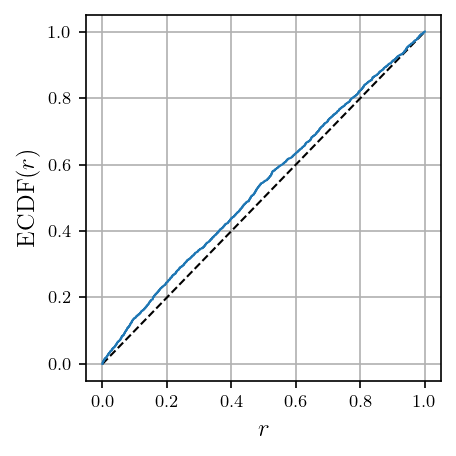

In [8]:
fig = rank_ecdf(ranks)
fig.savefig(runpath / 'ecdf.pdf')

## Corner

In [9]:
eventset = H5Dataset(datapath / 'event.h5')
theta_star, x_star = eventset[1]

In [10]:
with torch.no_grad():
    x = embedding(x_star.cuda())
    theta = torch.cat([
        estimator.sample(x, (2**14,)).cpu()
        for _ in tqdm(range(2**6))
    ])

100%|██████████| 64/64 [03:38<00:00,  3.41s/it]


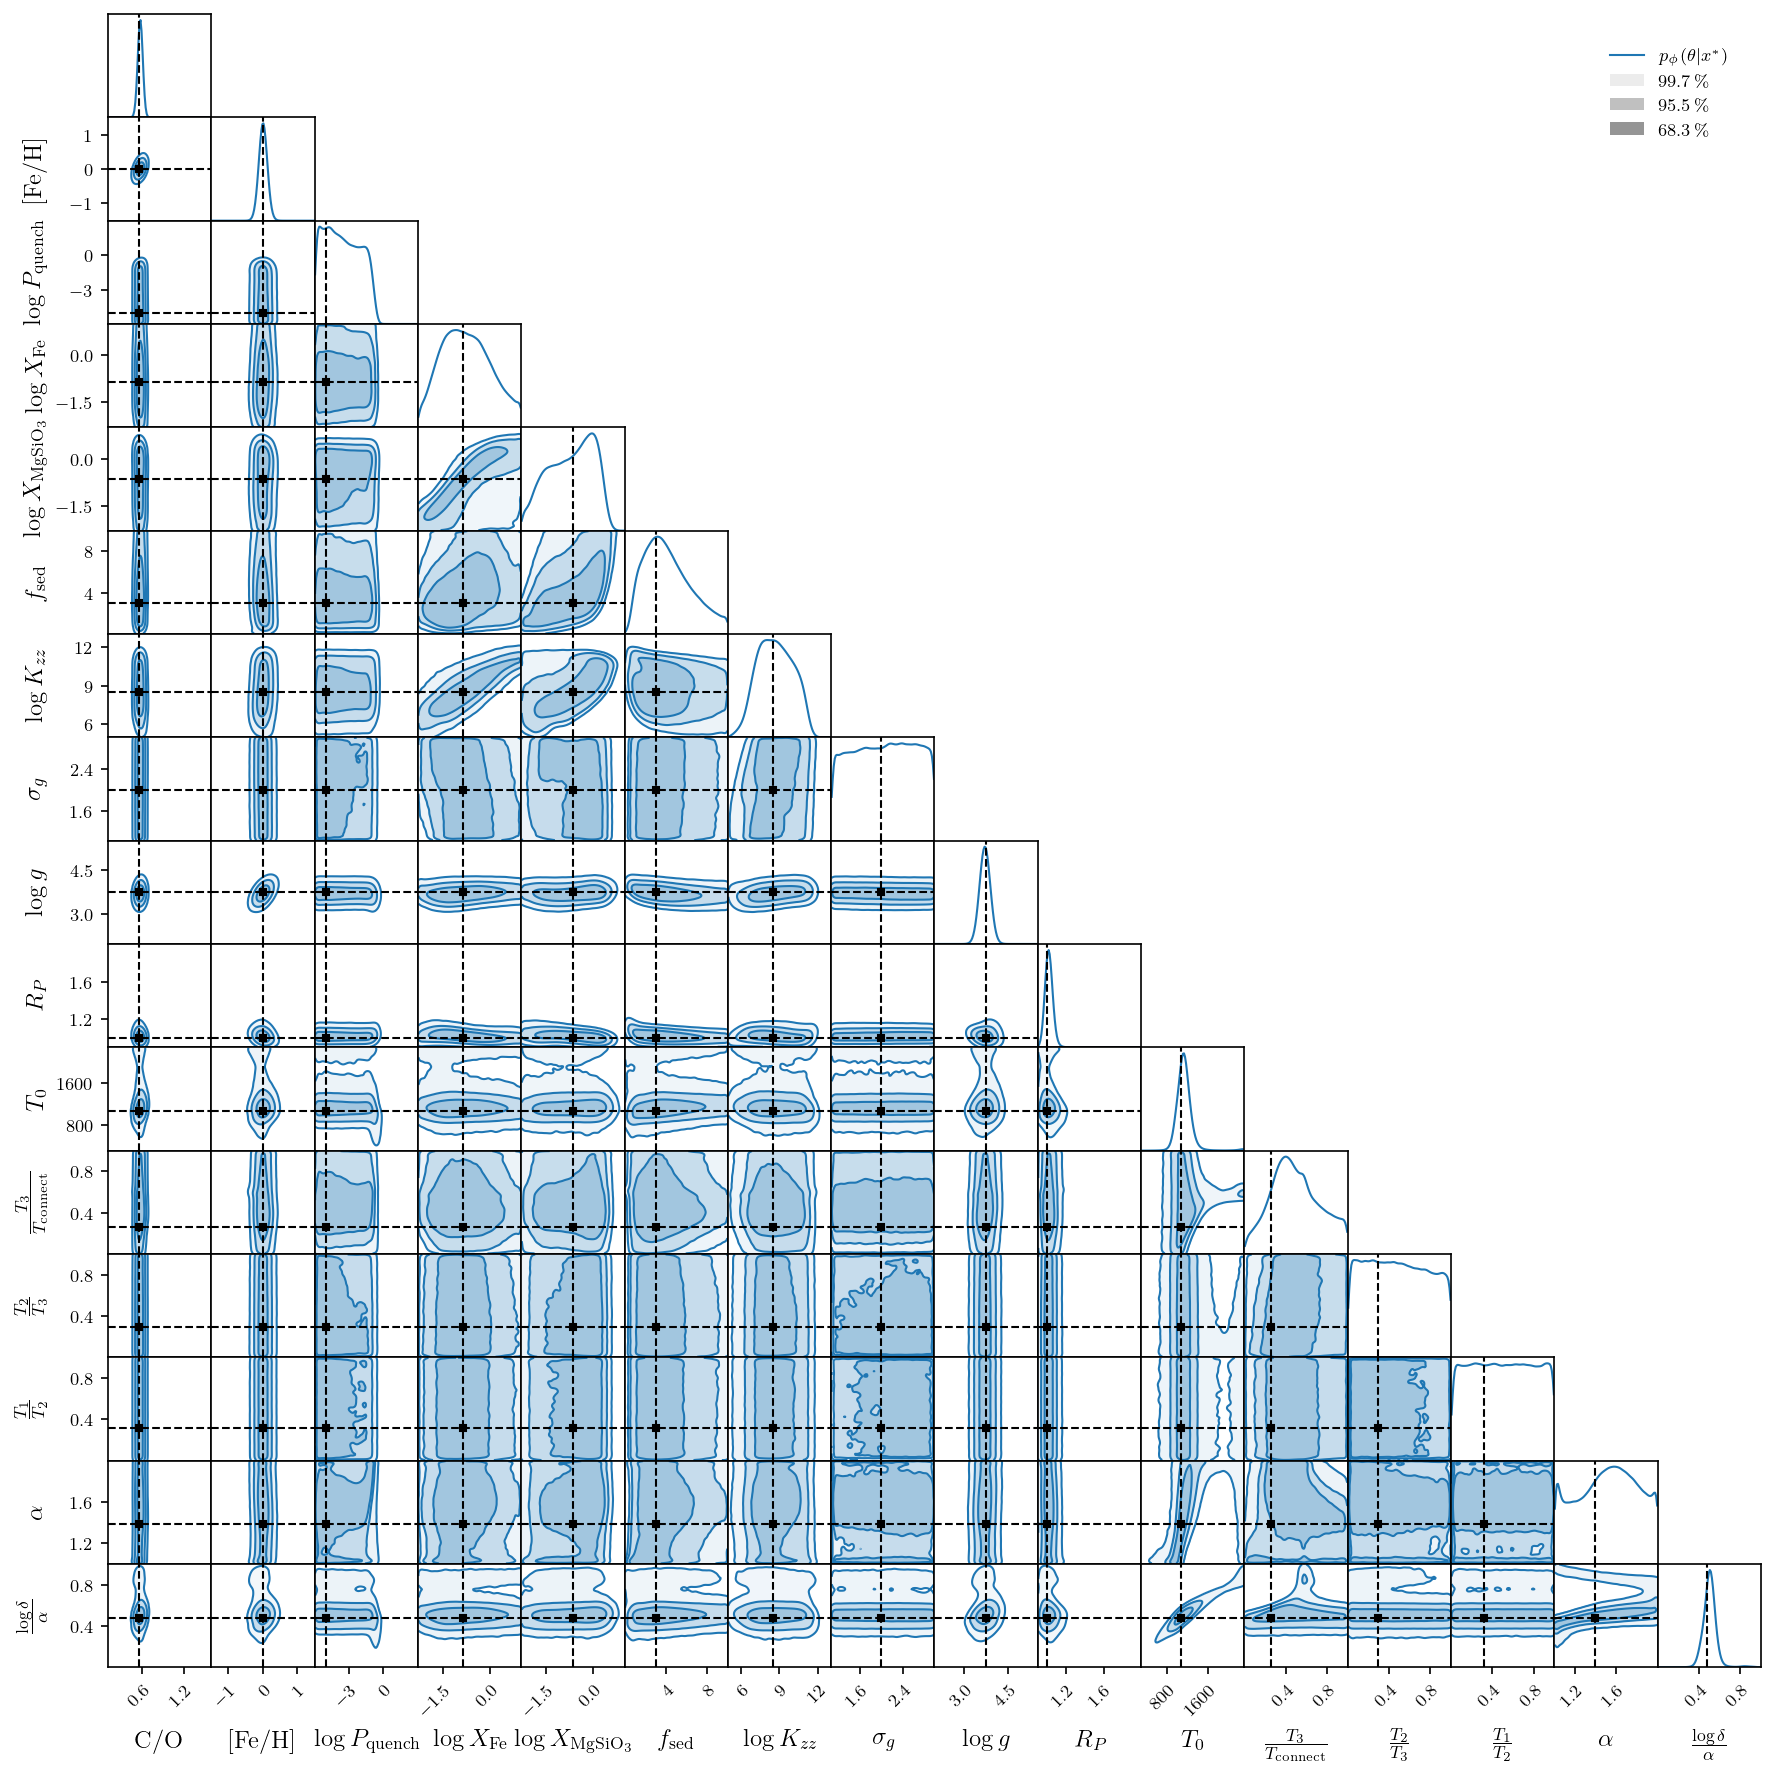

In [11]:
fig = corner(
    theta,
    smooth=2,
    bounds=(LOWER, UPPER),
    labels=LABELS,
    legend=r'$p_{\phi}(\theta | x^*)$',
    markers=[theta_star],
    figsize=(12, 12),
)
fig.savefig(runpath / 'corner.pdf')

## PT-profile

In [12]:
theta_star, x_star = theta_star.double().numpy(), x_star.double().numpy()
theta = theta[:256].double().numpy()

pressure = simulator.atmosphere.press / 1e6
temperature = pt_profile(theta, pressure)
temperature_star = pt_profile(theta_star, pressure)

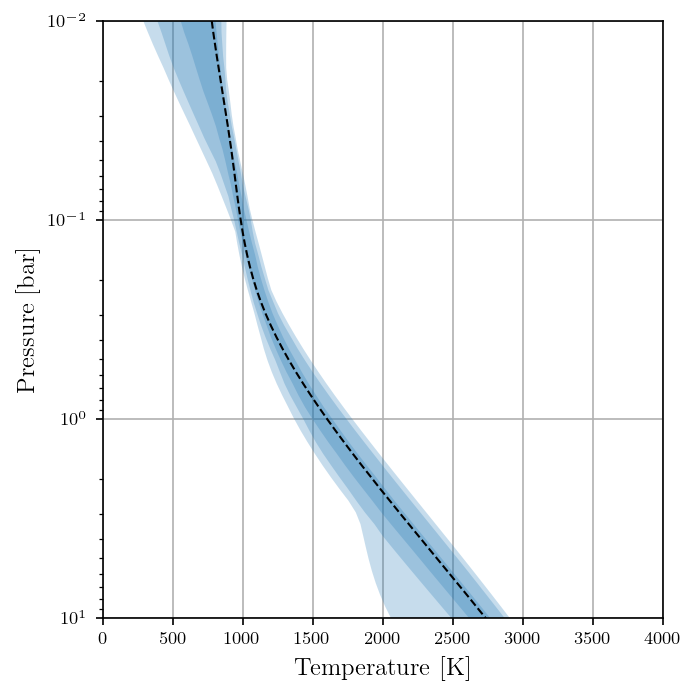

In [13]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))

for q in [0.997, 0.95, 0.68]:
    left, right = np.quantile(temperature, [0.5 - q / 2, 0.5 + q / 2], axis=0)
    ax.fill_betweenx(pressure, left, right, color='C0', alpha=0.25, linewidth=0)

ax.plot(temperature_star, pressure, color='k', linestyle='--')

ax.set_xlabel(r'Temperature $[\mathrm{K}]$')
ax.set_xlim(0, 4000)
ax.set_ylabel(r'Pressure $[\mathrm{bar}]$')
ax.set_ylim(1e-2, 1e1)
ax.set_yscale('log')
ax.invert_yaxis()
ax.grid()

fig.savefig(runpath / 'pt_profile.pdf')

## Consistency

In [14]:
x = np.stack([simulator(t) for t in tqdm(theta)])

mask = ~np.isnan(x).any(axis=-1)
theta, x = theta[mask], x[mask]

wlength = np.linspace(0.95, 2.45, x.shape[-1])

100%|██████████| 256/256 [25:20<00:00,  5.94s/it]


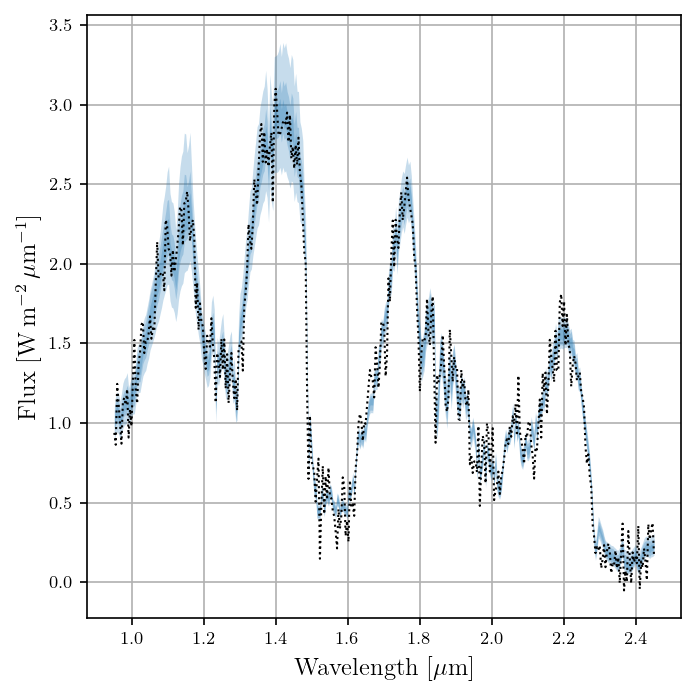

In [15]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))

for q in [0.997, 0.95, 0.68]:
    lower, upper = np.quantile(x, [0.5 - q / 2, 0.5 + q / 2], axis=0)
    ax.fill_between(wlength, lower, upper, color='C0', alpha=0.25, linewidth=0)

ax.plot(wlength, x_star, color='k', linestyle=':')

ax.set_xlabel(r'Wavelength $[\mu\mathrm{m}]$')
ax.set_ylabel(r'Flux $[\mathrm{W} \, \mathrm{m}^{-2} \, \mu\mathrm{m}^{-1}]$')
ax.grid()

fig.savefig(runpath / 'consistency.pdf')